# Audio Processing

- Sound is created by the compression of air due to vibrations.
- Depending on the degree of compression, it vibrates and is expressed as a **wave**, a phenomenon that propagates through space or a medium.
- Information that can be obtained from a wave:
  - Phase; Degrees of displacement
  - Amplitude; Intensity
  - Frequency

### Python Audio Library
- librosa is a useful Python library for various types of audio processing.
- I use "torchaudio" for audio dataset
- (!pip install torchaudio) & (!pip install librosa)

In [65]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-white") # optional

import librosa
import librosa.display
import torch
import torchaudio
import IPython.display as ipd
from torchaudio.datasets import LIBRISPEECH 
from scipy.signal import resample_poly

### Audio dataset
- Import the built-in dataset from torchaudio in PyTorch.
- It might take some time due to the dataset's size.

In [8]:
train_dataset = torchaudio.datasets.LIBRISPEECH("./", url = "train-clean-100", download = False)
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url = "test-clean", download = False)

100%|██████████████████████████████████████| 5.95G/5.95G [17:29<00:00, 6.09MB/s]
100%|████████████████████████████████████████| 331M/331M [00:57<00:00, 6.06MB/s]


- Check the imported dataset
  - The first array represents the audio data.
  - The second component represents the sampling rate of the data.
  - The length of the data alone does not indicate the duration (i.e., how many seconds the audio corresponds to).

In [29]:
test_dataset[1][0]

tensor([[ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]])

In [17]:
test_dataset[1][0].shape

torch.Size([1, 52400])

In [20]:
test_dataset[1][0]

tensor([[ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]])

# Sampling
- To process audio, analog information must be divided into smaller parts and represented as discrete digital data.
- Since it is impossible to store infinitely fine divisions, a standard is set to divide the analog information and use representative values, and this process is called **sampling**.
- The Time Domain method is commonly used, where analog information is divided based on **time**.

### Sampling rate
- The sampling rate determines how finely the analog information is divided.
- The finer the division, the less information is lost, but the data size increases.

### Sampling theorem
- The sampling rate must be at least twice the maximum frequency to accurately capture the signal.
- In general, sampling is designed to match the human auditory range.
  - **Audio CD**: 44.1 kHz (44100 samples/second)
  - **Speech communication**: 8 kHz (8000 samples/second) (e.g, phone calls)

### Duration Calculation
- The duration of audio can be determined by dividing the length of the data by the sampling rate:

$ \text{Duration (seconds)} = \frac{\text{Number of samples}}{\text{Sampling rate}} $


In [32]:
audio_data = test_dataset[1][0][0]
sampling_rate = test_dataset[1][1]

print(audio_data, sampling_rate)
print('length:', len(audio_data))
print('duration:', len(audio_data) / sampling_rate)

ipd.Audio(audio_data, rate = sampling_rate)

tensor([ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]) 16000
length: 52400
duration: 3.275


# Resampling
- Resampling is the process of adjusting the sampling rate of sampled data and performing resampling.
- When performing interpolation unilaterally, a low-pass filter is used.
- The current data is in Torch tensor, but librosa accepts NumPy arrays, so conversion is necessary.
- By reducing the sampling rate by half, we can observe that the length is also reduced by half.

In [40]:
audio_np = audio_data.numpy()
y_8k = resample_poly(audio_np, 8000, sampling_rate)
print(len(audio_np), len(y_8k))
ipd.Audio(y_8k, rate = 8000)

52400 26200


In [41]:
audio_np = audio_data.numpy()
y_4k = resample_poly(audio_np, 4000, sampling_rate)
print(len(audio_np), len(y_4k))
ipd.Audio(y_4k, rate = 4000)

52400 13100


# Normalization & Quantization
- When the volume levels of different data samples vary significantly, normalization is applied to adjust the amplitude within the range [-1, 1].
- Here, we use the simplest method: dividing the data by its maximum absolute value.

In [43]:
audio_np = audio_data.numpy()
normed_wav = audio_np / max(np.abs(audio_np))
ipd.Audio(normed_wav, rate = sampling_rate)

In [44]:
bit = 8
max_value = 2 ** (bit - 1)

quantized_8_wav = normed_wav * max_value
quantized_8_wav = np.round(quantized_8_wav).astype(int)
quantized_8_wav = np.clip(quantized_8_wav, -max_value, max_value-1)
ipd.Audio(quantized_8_wav, rate = sampling_rate)

# Mu-Law Encdoing
- The human ear is highly sensitive to small differences in quiet sounds but becomes less perceptive to differences as sounds get louder.
- This characteristic is reflected in the representation of wave values, ensuring higher resolution for small values and lower resolution for larger values.

In [48]:
def mu_law(x, mu=255):
    return np.sign(x) * np.log(1 + mu * np.abs(x)) / np.log(1 + mu)

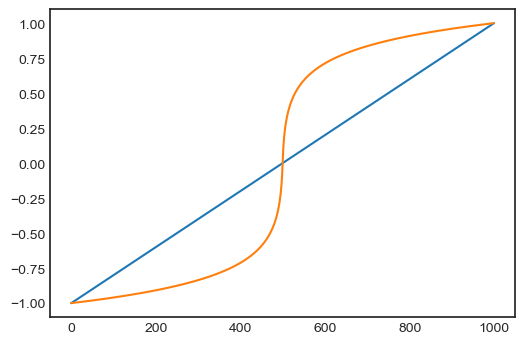

In [50]:
x = np.linspace(-1, 1, 1000)
x_mu = mu_law(x)

plt.figure(figsize = (6, 4))
plt.plot(x)
plt.plot(x_mu)
plt.show()

- The orange line represents the result of applying μ-law (mu-law) compression to x.

In [51]:
wav_mulaw = mu_law(normed_wav)
ipd.Audio(wav_mulaw, rate = sampling_rate)

- The volume differences in the audio have increased.
- To some extent, we can perceive that the sound has become louder in the audible range.

# Audio Representation
- Representation of sampled discrete data
  - Time-Domain Representation: Viewing the magnitude of air pressure waves over time.
  - Time-Frequency Representation: Observing changes in frequency over time.

### Waveform - Time-Domain Representation
- A waveform is the natural representation of audio.
- The x-axis represents time, while the y-axis represents amplitude.

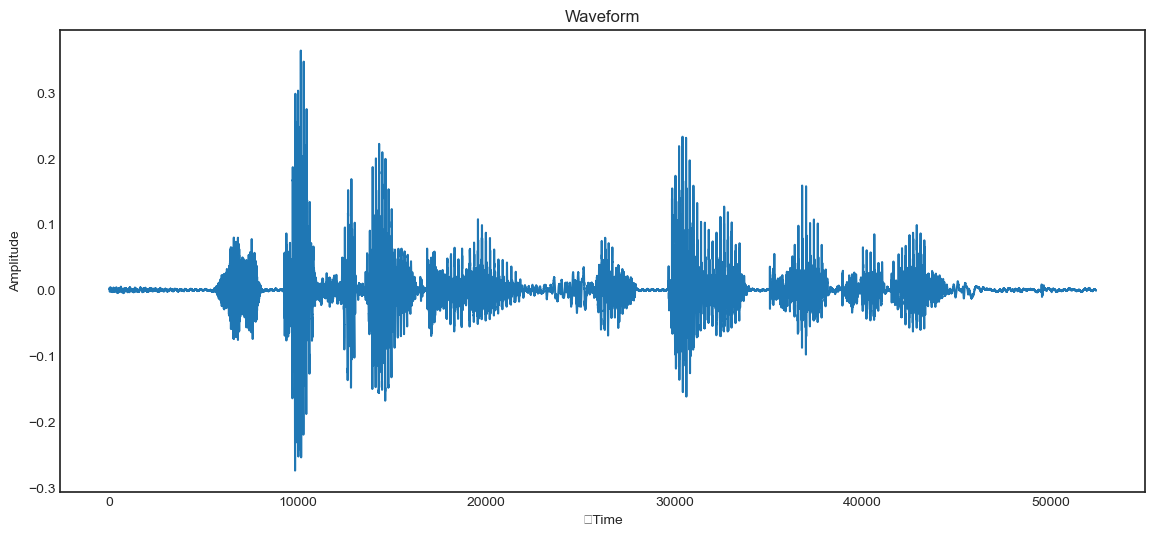

In [73]:
audio_np = audio_data.numpy()

plt.figure(figsize=(14, 6))
plt.plot(audio_np[:100000])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Waveform");

### Sinusoid - Time-Frequency Representation
- Any signal can be represented as a combination of sinusoidal signals with different frequencies, magnitudes, and phases.
- Fourier Transform is a method that separates the individual sinusoidal components from a combined harmonic signal.

In [76]:
def Sinusoid(A, f, phi, fs, t):
    t = np.arange(0, t, 1.0/fs)
    x = A * np.cos(2 * np.pi * f * t + phi)
    return x

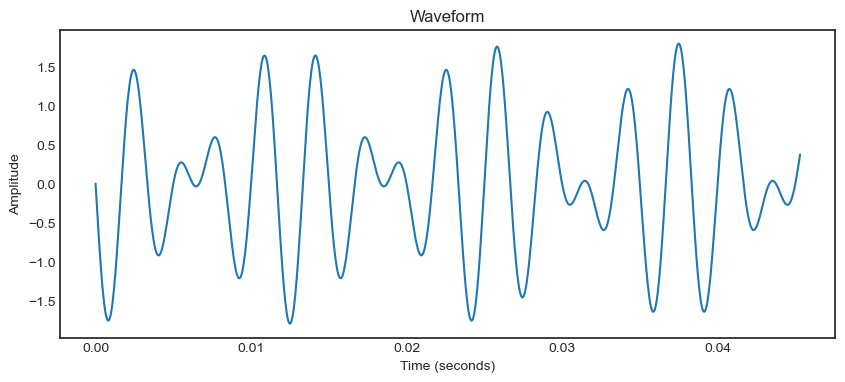

In [90]:
sin = Sinusoid(0.9, 340, np.pi/2, 22050, 1)
sin2 = Sinusoid(0.9, 260, np.pi/2, 22050, 1)
complexwav = sin + sin2

duration = len(complexwav) / 22050 
time = np.linspace(0, duration, len(complexwav), endpoint=False) 

plt.figure(figsize=(10, 4))
plt.plot(time[:1000], complexwav[:1000]) 
plt.xlabel("Time (seconds)")  
plt.ylabel("Amplitude")
plt.title("Waveform");

In [91]:
ipd.Audio(sin + sin/2 + sin/4, rate = 22050)

In [92]:
ipd.Audio(sin2 + sin2/2 + sin2/4, rate = 22050)

In [93]:
def generate_sinusoid_scale(pitches=[69], duration=0.5, fs=22050, amplitude_max=0.5):
    N = int(duration * fs)
    t = np.arange(N) / fs
    x = []
    for p in pitches:
        omega = 2 ** ((p - 69) / 12) * 440
        x = np.append(x, np.sin(2 * np.pi * omega * t))
    x = amplitude_max * x / np.max(x)
    return x

In [95]:
duration = 1
fs = 22050
pitches = [36, 48, 60, 74, 84, 96]
x = generate_sinusoid_scale(pitches=pitches, duration = duration, fs=fs)
print('Pitch class C = {..., C1, C2, C3, C4, C5, C6, ...}')
ipd.display(ipd.Audio(data=x, rate = fs))

Pitch class C = {..., C1, C2, C3, C4, C5, C6, ...}


# Fourier Transform